In [572]:
import numpy as np
import pandas as pd

%matplotlib inline
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import keras 
import keras.backend as K
from keras.layers import Input, Dense, Dropout, GaussianNoise, LeakyReLU, BatchNormalization
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import impyute as impy





In [416]:
# import data
y_all = pd.read_csv('fraudlabels.csv',names=["fraud"])
# feature names and data are in different csv files
with open(r"attributes.csv","r", encoding='utf8') as f:
    cr = csv.reader(f,delimiter=" ")
    features = list(cr)  # create a list of rows for instance
features = [x[0] for x in features]
X_all = pd.read_csv('fraudnumerics.csv',names=features)
# no type conversions required 

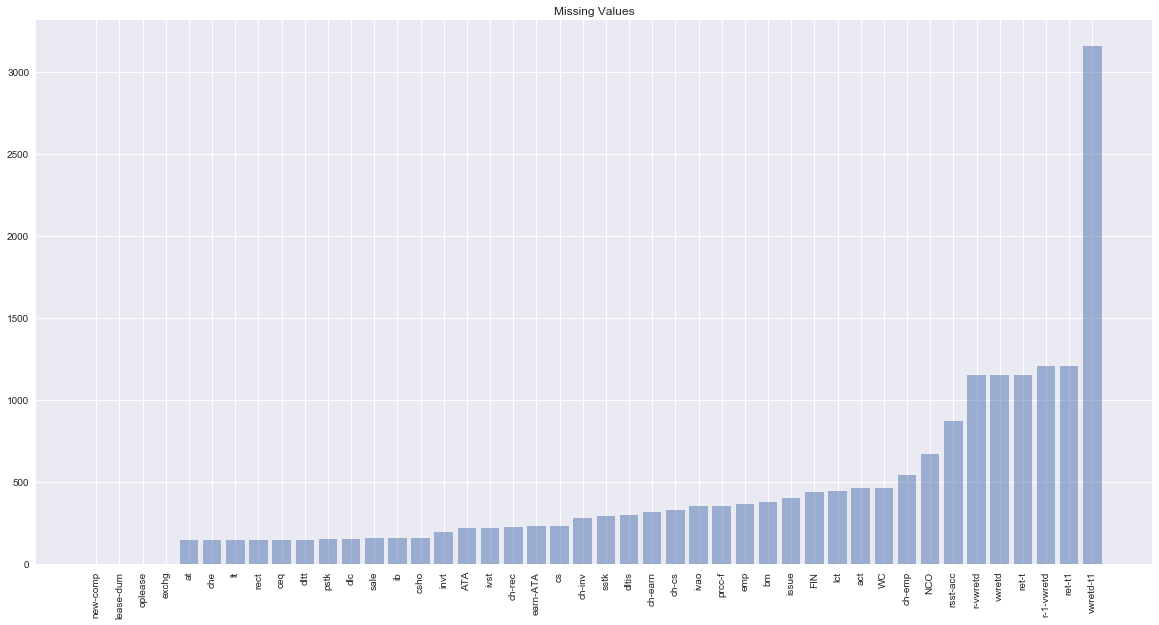

In [417]:
# bar graph for missing values in pandas dataframe
objects = features
y_pos = np.arange(len(objects))
missing = pd.DataFrame({"null":X_all.isnull().sum().sort_values()})
plt.figure(figsize=(20,10))
plt.bar(y_pos, missing["null"], align='center', alpha=0.5)
plt.xticks(y_pos, missing.index, rotation='vertical')

plt.ylabel('')
plt.title('Missing Values')
 
plt.show()


In [418]:
# count NaN values in each column
missing['missing/total']  = missing['null']/ X_all.shape[0]

print(missing.head())
# A lot of missing data
# going to delete data with more than 25% data missing
# get columns that fit into this category 
# don'tknow the meaning of the features - if given I could make more educated guesses about which columns can be dropped
drop_rate = 0.25
to_drop = missing.index[missing['missing/total'] > drop_rate].tolist()
print(to_drop)
# check all columns' data types
print(X_all.dtypes.head())
# all column types are numeric

#What is the spread of missing numbers

           null  missing/total
new-comp      0       0.000000
lease-dum     0       0.000000
oplease       0       0.000000
exchg         0       0.000000
at          144       0.045613
['rsst-acc', 'r-vwretd', 'vwretd', 'ret-t', 'r-1-vwretd', 'ret-t1', 'vwretd-t1']
act     float64
at      float64
ceq     float64
che     float64
csho    float64
dtype: object


In [419]:
print("X shape: ", X_all.shape)
print("y shape: ",y_all.shape)
['rsst-acc', 'r-vwretd', 'vwretd', 'ret-t', 'r-1-vwretd', 'ret-t1', 'vwretd-t1']

#dropping columns with more than 25% of data missing until I find out column labels
X_all = X_all.drop(columns=to_drop)
print("X shape: ", X_all.shape)


X shape:  (3157, 44)
y shape:  (3157, 1)
X shape:  (3157, 37)


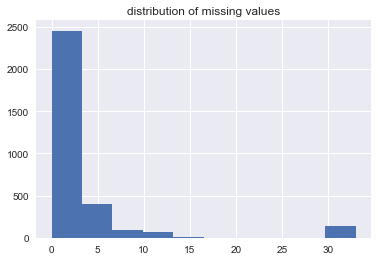

In [420]:
#look at rows with missing data 
X_all.isnull().sum(axis=1).hist()
plt.title("distribution of missing values")
plt.show()
temp_X = pd.DataFrame({"rownull":X_all.isnull().sum(axis=1)})
#there is a group of ~ 100 row missing 29 or more values
# get index of these rows and drop 
drop_rate_row = 25
# returns which rows to drop in both X and Y dataframe
to_drop = temp_X.index[temp_X['rownull'] > drop_rate_row].tolist()



In [421]:
#check that rows bring dropped not all fraud  - 
print(y_all.iloc[to_drop].shape)
print(y_all.iloc[to_drop].sum())

(144, 1)
fraud    8
dtype: int64


In [422]:
#how many rows are going to be dropped?
print(len(to_drop))
#axis = 0, dropping rows
X_all = X_all.drop(to_drop,axis=0)
y_all = y_all.drop(to_drop,axis=0)



144


X shape:  (3013, 37)
y shape:  (3013, 1)


Text(0.5,1,'distribution of missing values')

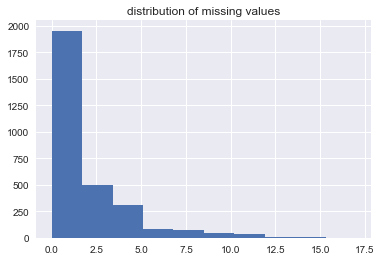

In [423]:
print("X shape: ", X_all.shape)
print("y shape: ",y_all.shape)
X_all.isnull().sum(axis=1).hist()
plt.title("distribution of missing values")

# IF ROWS BEING DROPPED ARE MOSTLY FRAUDULENT THIS MIGHT BE IMPORTANT need to look into this laters
# now rows are missing at most 15 features out of 37



In [424]:
#Imputing missing values with mean from column
#X_all = X_all.fillna(X_all.mean())
temp = impy.em(X_all.values)
X_all[X_all.columns] = temp


In [425]:
print("X shape ", X_all.shape)
print("y shape ",y_all.shape)

f = y_all.fraud.sum()
n = y_all.shape[0]-f
print("fraud ", f)
print("normal ", n)
print("fraud/all", round(f/X_all.shape[0],2))

X shape  (3013, 37)
y shape  (3013, 1)
fraud  621
normal  2392
fraud/all 0.21


In [426]:
X_all=X_all.reset_index(drop=True)
y_all=y_all.reset_index(drop=True)

In [427]:
X_all.to_csv('X.csv')
y_all.to_csv('y.csv')

In [428]:
y_all.isnull().sum()

fraud    0
dtype: int64

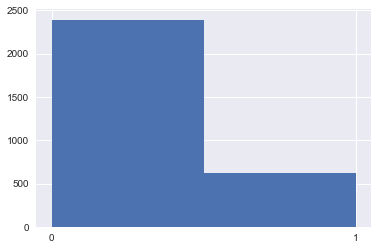

Not fraud (0),  2392
Fraud (1),  621


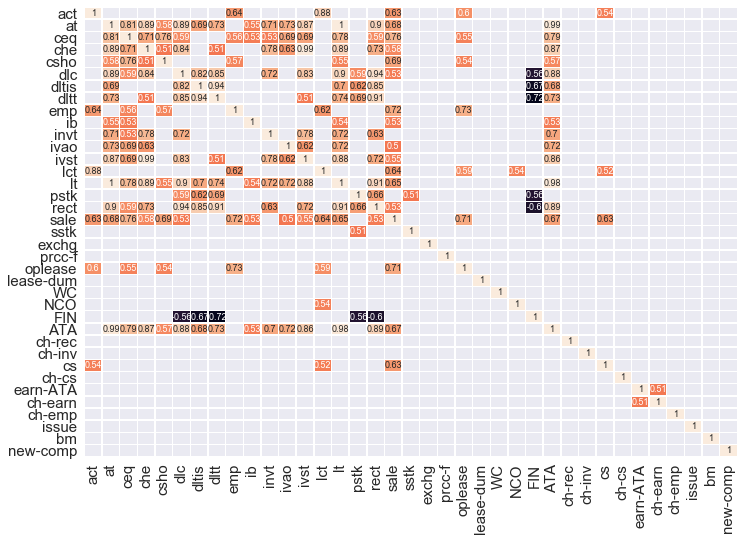

In [429]:
#print(X_all.describe())
# need to add titles to histograms
y = [y_all.fraud.sum(), y_all[y_all.fraud == 0].shape[0]]
plt.hist(y_all, bins=2)
plt.show()
sns.set(rc={'figure.figsize':(11.7,8.27)})
corr = X_all.corr()
fig, ax = plt.subplots()
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)],xticklabels=True, yticklabels=True, linewidths=.5, ax=ax, annot=True,annot_kws={"size": 9},cbar=False)
ax.tick_params(labelsize=15)
print("Not fraud (0), ",y[1])
print("Fraud (1), ",y[0])

In [430]:
#http://www.iro.umontreal.ca/~pift6266/H10/notes/SdA.html

In [431]:
def allHistograms(df):
    for i, col in enumerate(df.columns):
        plt.figure(i)
        plt.hist(df[col],bins=20,normed=True)
        plt.title(col + " (20 bins)")

def pairwiseHistogramsScatter(start,stop, df,y):
    sns.set(font_scale=2)
    temp = df[df.columns[start:stop]]
    temp["fraud"] = y["fraud"]
    g = sns.PairGrid(temp, hue="fraud")
    g.map_diag(plt.hist)
    g.map_offdiag(plt.scatter)
    g.add_legend();
    
    

In [458]:
#pairwiseHistogramsScatter(20,37,X_all,y_all)


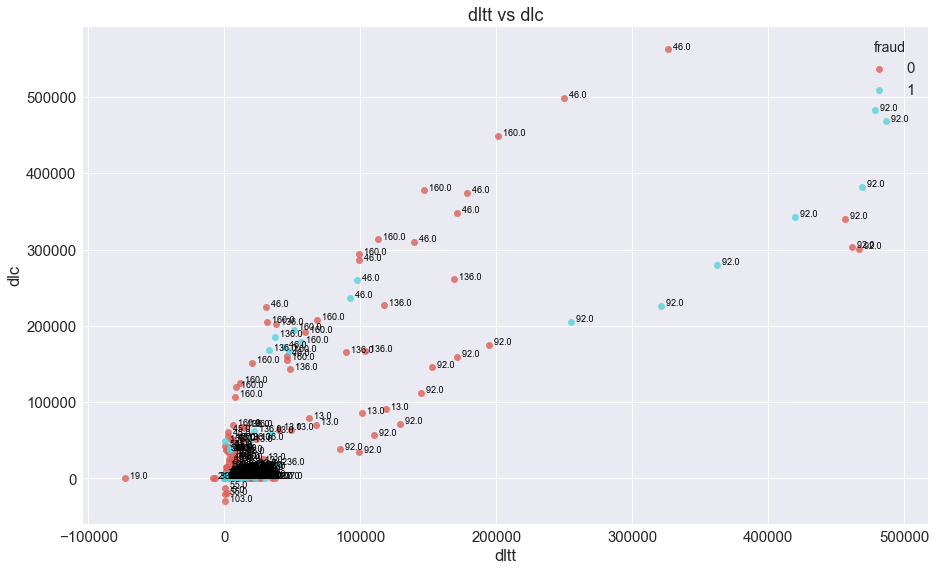

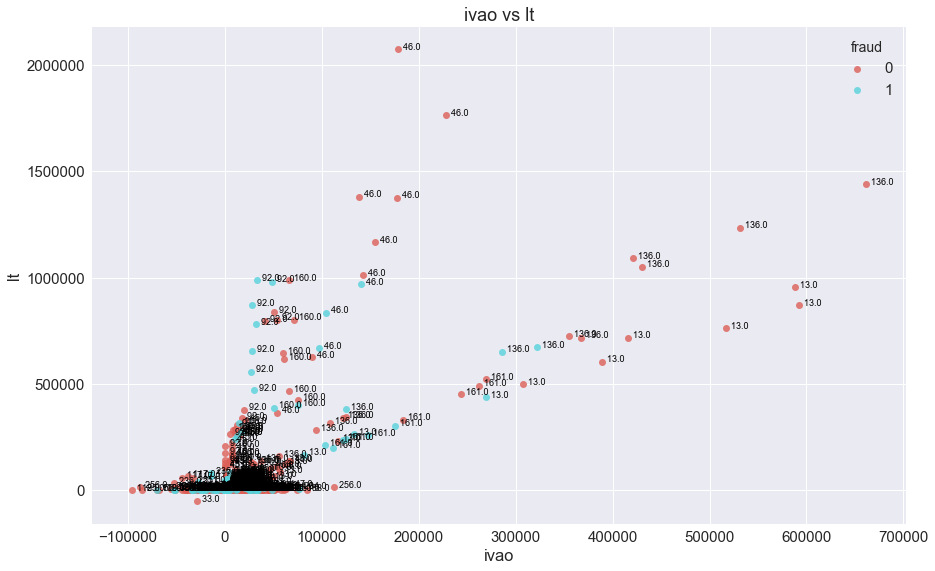

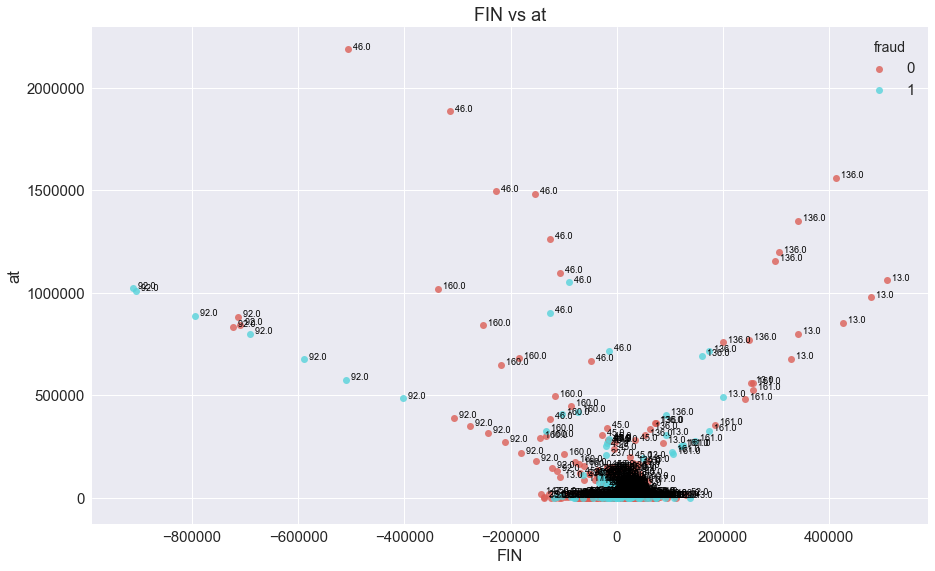

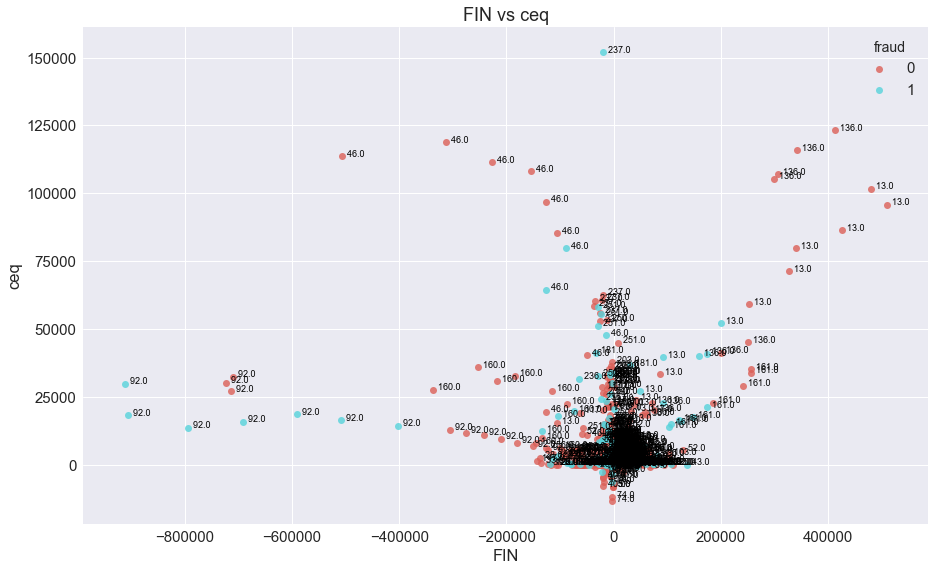

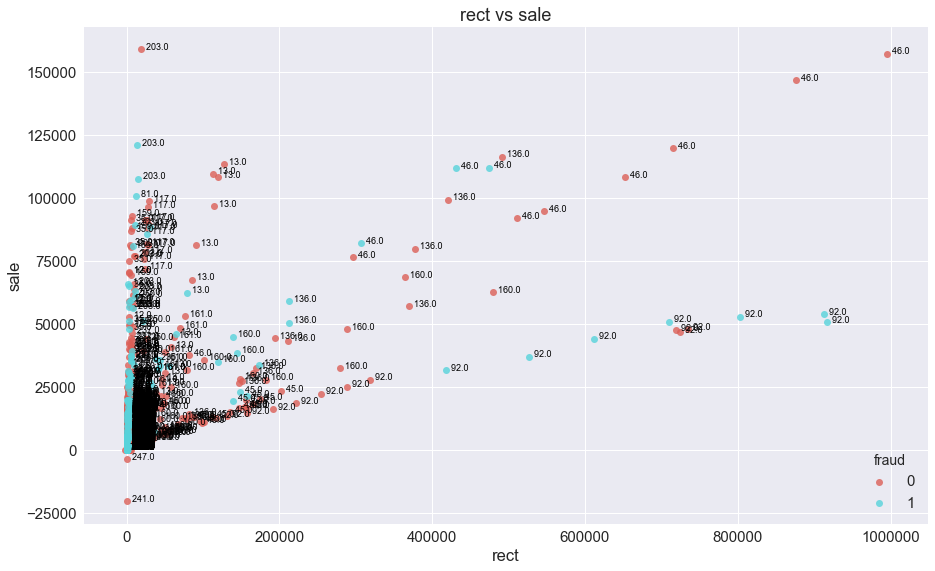

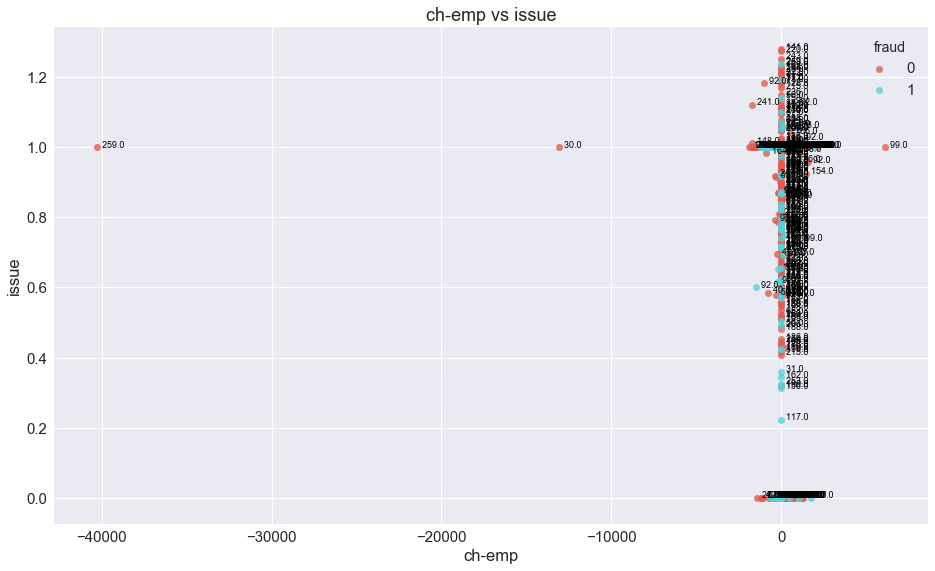

In [457]:

def scatterpairwise(x_col,y_col,text,label,scatterdf):
    sns.set(font_scale=1.5)
    sns.lmplot(x=x_col , y=y_col, data=scatterdf, hue=label,palette='hls', fit_reg=False,size= 8, aspect=5/3, legend_out=False)
    plt.title(x_col + " vs "+y_col)
    for line in range(0,scatterdf.shape[0]):
        plt.text(scatterdf[x_col].iloc[line]+0.2, scatterdf[y_col].iloc[line], "  "+str(scatterdf[text].iloc[line]), 
             horizontalalignment='left', size=9, color='black')
    
scatterdf = X_all.copy(deep=True)
scatterdf["fraud"] = y_all["fraud"]

scatterpairwise('dltt','dlc','new-comp','fraud',scatterdf)
scatterpairwise('ivao','lt','new-comp','fraud',scatterdf)
scatterpairwise('FIN','at','new-comp','fraud',scatterdf)
scatterpairwise('FIN','ceq','new-comp','fraud',scatterdf)
scatterpairwise('rect','sale','new-comp','fraud',scatterdf)


In [459]:
# Need to split data into train validation test 
X_train, X_test, y_train, y_test = train_test_split(X_all.values, y_all.values, test_size=0.4, stratify=y_all.values,random_state=42, shuffle=True)
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test,stratify=y_test, test_size=0.5, random_state=42, shuffle=True)
print("Train: ", X_train.shape)
print("Validate: ", X_validate.shape)
print("Test: ", X_test.shape)

transformer = MinMaxScaler(feature_range=(0, 1)).fit(X_train)
X_train = transformer.transform(X_train)
X_validate = transformer.transform(X_validate)
X_test = transformer.transform(X_test)

# create noisy data for train and test
noise_factor = 0.5
x_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
x_validate_noisy = X_validate + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_validate.shape)
x_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_validate_noisy = np.clip(x_validate_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Train:  (1807, 37)
Validate:  (603, 37)
Test:  (603, 37)


In [782]:
def autoencoder(numFeatures):
    #input
    inData = Input(shape=(numFeatures,))
    act2 = 'sigmoid'
    #encoding
    rate = 0.5
    dr = Dropout(rate, noise_shape=None, seed=42)(inData)
    encoded = Dense(8, activation=act2, 
                kernel_initializer=keras.initializers.RandomUniform(seed=42),kernel_regularizer=regularizers.l1(0.01))(dr)
    dr = Dropout(rate, noise_shape=None, seed=42)(encoded)
    
    #latent layer
    latent = Dense(3,activation= act2)(dr)
    dr = Dropout(rate, noise_shape=None, seed=42)(latent)
    
    #decoding
    decoded = Dense(8,activation= act2)(dr)
    dr = Dropout(rate, noise_shape=None, seed=42)(decoded)
    
    outData = Dense(numFeatures, activation="sigmoid")(dr)
    autoencoder = Model(inData, outData)
    return autoencoder


In [783]:
batch_size = 32
epochs = 1000
# input shape is 1x# of features
features = X_all.shape[1]
ae = autoencoder(features)
ae.summary()

ae.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False))

# lr=0.00001

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 37)                0         
_________________________________________________________________
dropout_195 (Dropout)        (None, 37)                0         
_________________________________________________________________
dense_205 (Dense)            (None, 8)                 304       
_________________________________________________________________
dropout_196 (Dropout)        (None, 8)                 0         
_________________________________________________________________
dense_206 (Dense)            (None, 3)                 27        
_________________________________________________________________
dropout_197 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_207 (Dense)            (None, 8)                 32        
__________

In [784]:
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                      write_graph=True,
                          write_images=True)


history = ae.fit(x_train_noisy, X_train, batch_size=batch_size, epochs=epochs,
          verbose=0, shuffle=True, validation_data=(x_validate_noisy, X_validate),
          callbacks=[checkpointer, tensorboard]).history


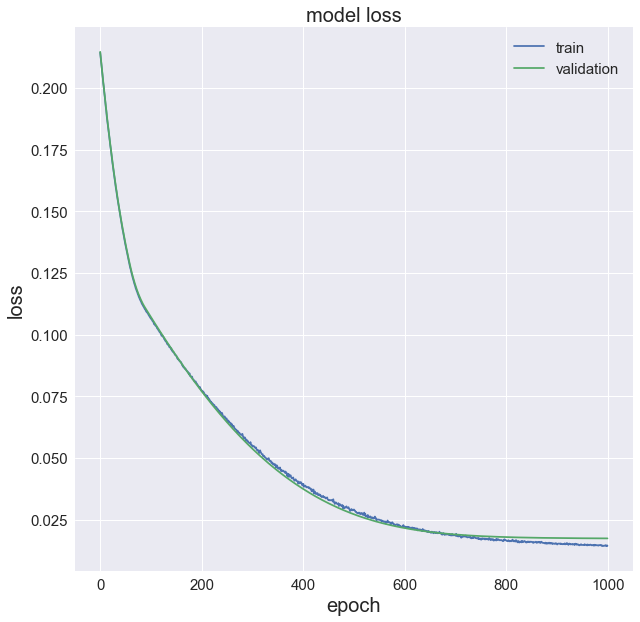

In [785]:
fig = plt.figure(figsize = (10,10))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss',size=20)
plt.ylabel('loss',size=20)
plt.xlabel('epoch',size=20)
plt.legend(['train', 'validation'], loc='upper right');



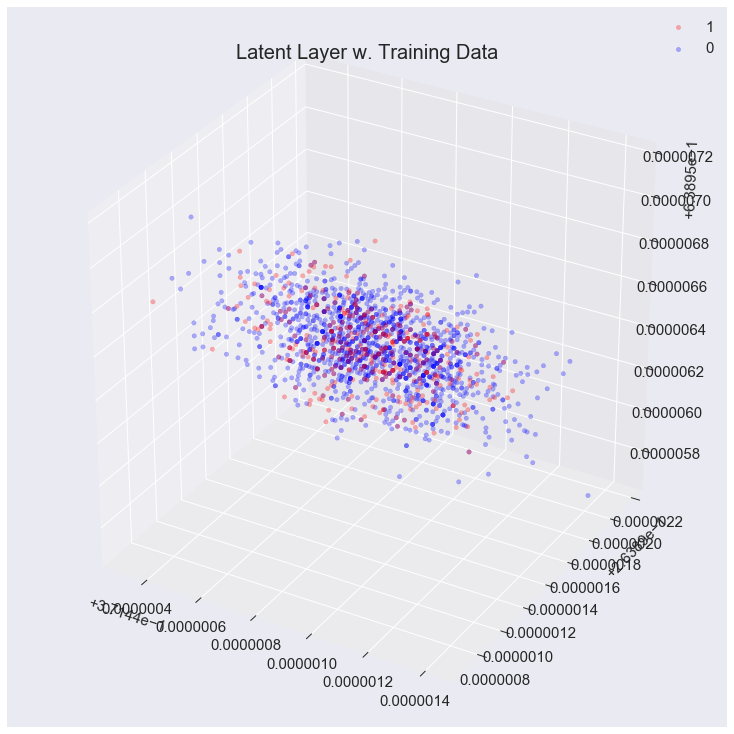

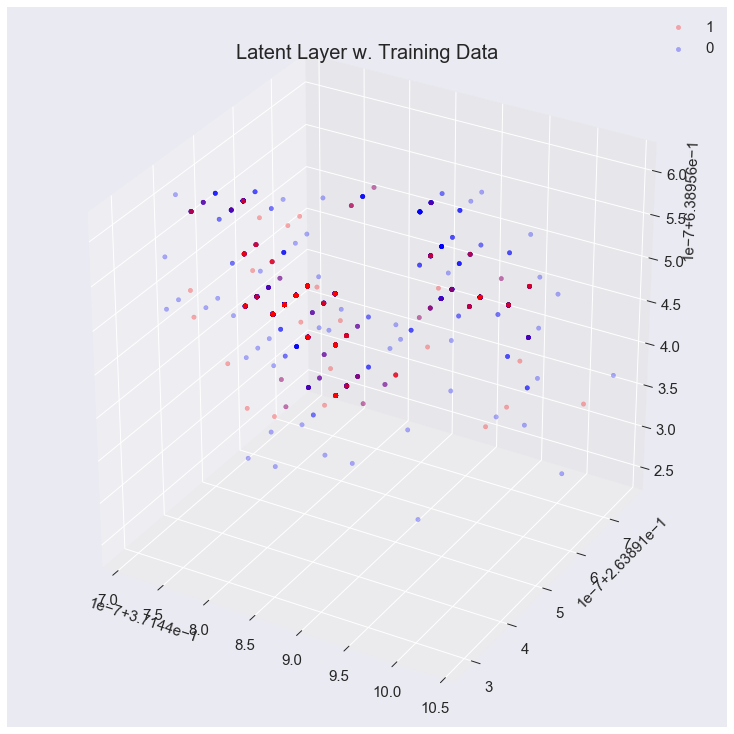

In [788]:
# noisy train
latent_layer = K.function([ae.layers[0].input], [ae.layers[4].output])
compressed = latent_layer([x_train_noisy])[0]
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
#ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Training Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_train == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2]
               , c = colour
               ,alpha=0.3,label=str(target),s=20)
    ax.legend()
    
# train
latent_layer = K.function([ae.layers[0].input], [ae.layers[4].output])
compressed = latent_layer([X_train])[0]
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
#ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Training Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_train == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2]
               , c = colour
               ,alpha=0.3,label=str(target),s=20)
    ax.legend()



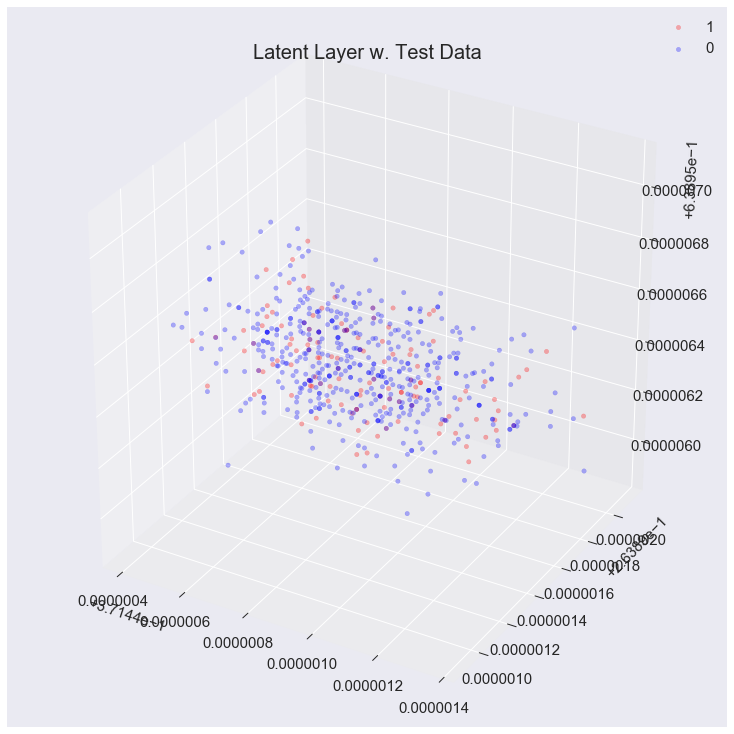

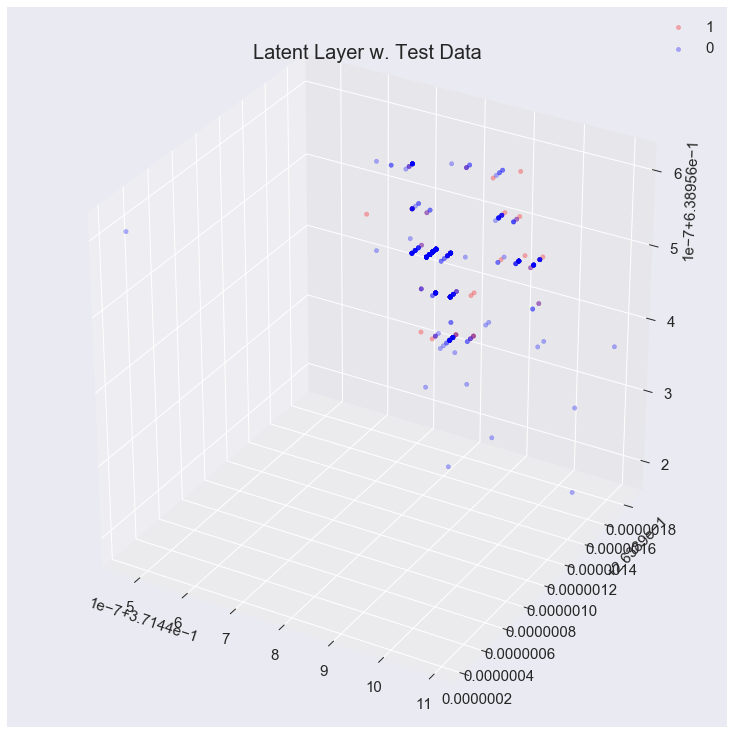

In [789]:
latent_layer = K.function([ae.layers[0].input], [ae.layers[4].output])
compressed = latent_layer([x_test_noisy])[0]
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Test Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_test == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2],
                c = colour
               ,  alpha=0.3,label=str(target),s=20)
    ax.legend()

latent_layer = K.function([ae.layers[0].input], [ae.layers[4].output])
compressed = latent_layer([X_test])[0]
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Test Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_test == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2],
                c = colour
               ,  alpha=0.3,label=str(target),s=20)
    ax.legend()



### Stacked Denoising Autoencoder using https://github.com/AmirAlavi/tied-autoencoder-keras


In [636]:
from tied_autoencoder_keras import DenseLayerAutoencoder

In [769]:
inputs =Input(shape=(X_all.shape[1],))
x = DenseLayerAutoencoder([8, 3], activation='sigmoid',dropout=0.5)(inputs)
model = Model(inputs=inputs, outputs=x)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 37)                0         
_________________________________________________________________
dense_layer_autoencoder_5 (D (None, 37)                376       
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________
None


In [770]:
batch_size = 32
epochs = 1000
# input shape is 1x# of features
features = X_all.shape[1]

model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False))


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                      write_graph=True,
                          write_images=True)


history = model.fit(x_train_noisy, X_train, batch_size=batch_size, epochs=epochs,
          verbose=0, shuffle=True, validation_data=(x_validate_noisy, X_validate),
          callbacks=[checkpointer, tensorboard]).history



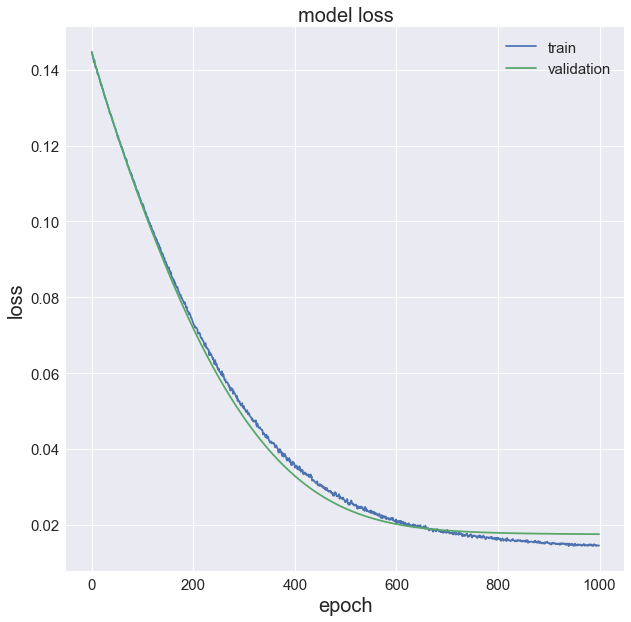

In [771]:
fig = plt.figure(figsize = (10,10))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss',size=20)
plt.ylabel('loss',size=20)
plt.xlabel('epoch',size=20)
plt.legend(['train', 'validation'], loc='upper right');


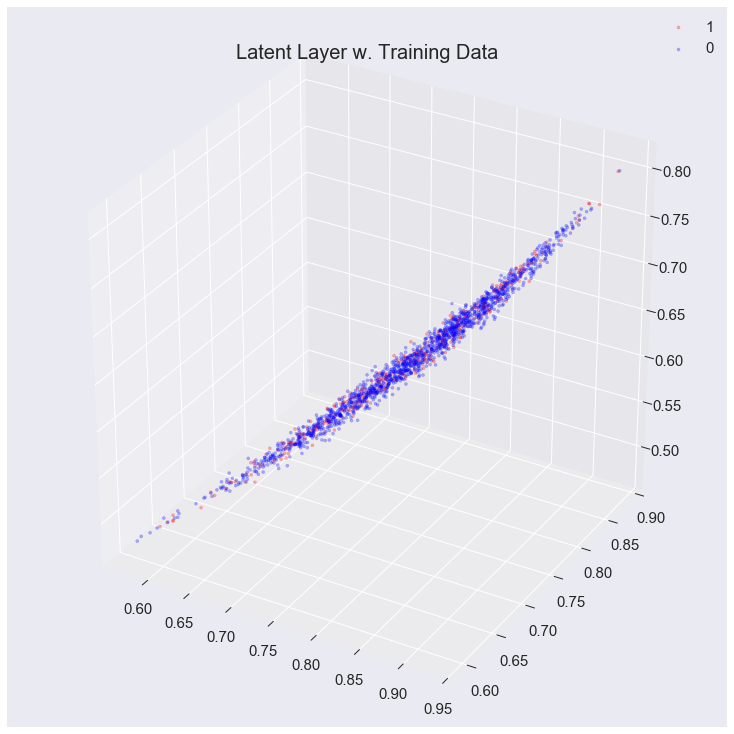

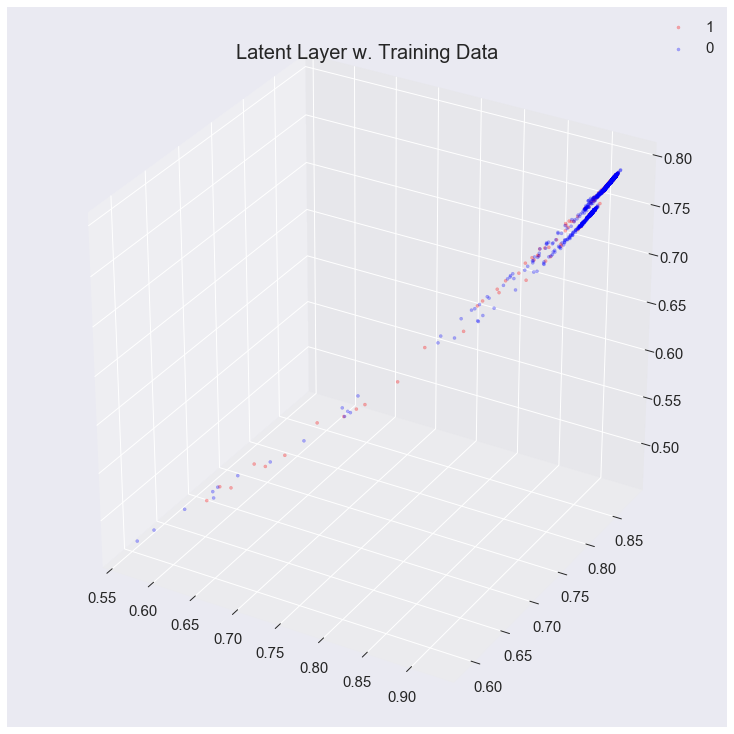

In [774]:
latent_layer = K.function([model.layers[1].input], [model.layers[1].encode(inputs)])
compressed = latent_layer([x_train_noisy])[0]

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
#ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Training Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_train == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2]
               , c = colour
               ,alpha=0.3,label=str(target),s=10)
    ax.legend()


latent_layer = K.function([model.layers[1].input], [model.layers[1].encode(inputs)])
compressed = latent_layer([X_train])[0]

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
#ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Training Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_train == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2]
               , c = colour
               ,alpha=0.3,label=str(target),s=10)
    ax.legend()

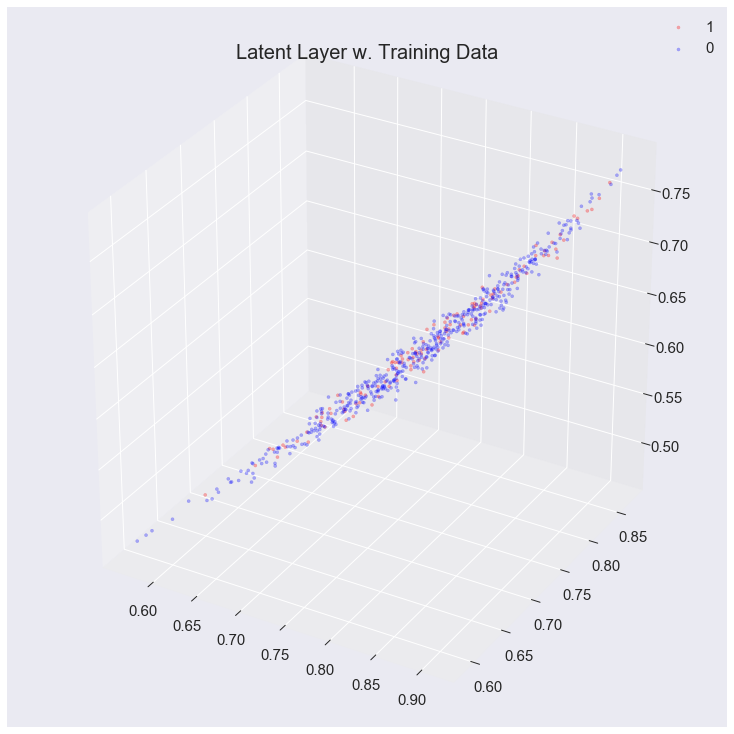

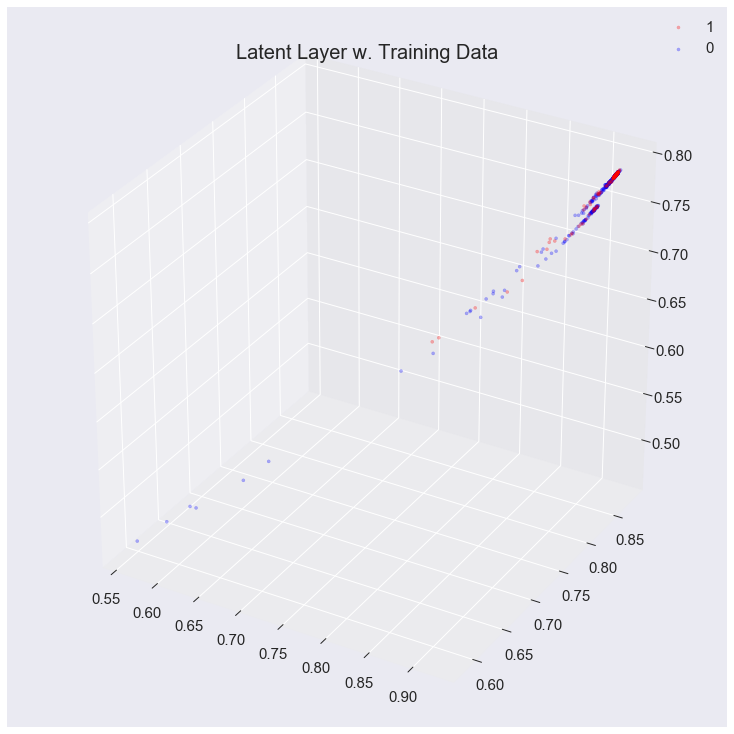

In [773]:
latent_layer = K.function([model.layers[1].input], [model.layers[1].encode(inputs)])
compressed = latent_layer([x_test_noisy])[0]

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
#ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Training Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_test == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2]
               , c = colour
               ,alpha=0.3,label=str(target),s=10)
    ax.legend()
    
    
latent_layer = K.function([model.layers[1].input], [model.layers[1].encode(inputs)])
compressed = latent_layer([X_test])[0]

fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)
#ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('', fontsize = 15)
ax.set_ylabel('', fontsize = 15)
ax.set_title('Latent Layer w. Training Data', fontsize = 20)
targets = [1,0]
colours = ['r', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = y_test == target
    ax.scatter(compressed[indicesToKeep[:,0],0]
               , compressed[indicesToKeep[:,0],1],
               compressed[indicesToKeep[:,0],2]
               , c = colour
               ,alpha=0.3,label=str(target),s=10)
    ax.legend()